In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from patsy import dmatrices

In [41]:
data_properties = ['nfeature', 'hlr', 'Correlation', 'Transition', 'Shifting', 'Seasonality', 'Trend', 'Stationarity']
configurations = ['norm', 'sd', 'fusion', 'embed', 'ff']
target = 'rank'

In [42]:
df = pd.read_csv("res_m_processed.csv")

In [43]:
df.keys()

Index(['dataset', 'nfeature', 'hlr', 'Correlation', 'Transition', 'Shifting',
       'Seasonality', 'Trend', 'Stationarity', 'norm', 'sd', 'fusion', 'embed',
       'ff', 'rank'],
      dtype='object')

In [44]:
df['Correlation_bin'] = pd.qcut(df['Correlation'], q=3, labels=False)
result = df.groupby(['Correlation_bin', 'norm'])['rank'].mean().reset_index()
print(result)

   Correlation_bin   norm       rank
0                0  False  22.388889
1                0   True  15.074713
2                1  False  19.030075
3                1   True  17.397695
4                2  False  16.367299
5                2   True  16.526022


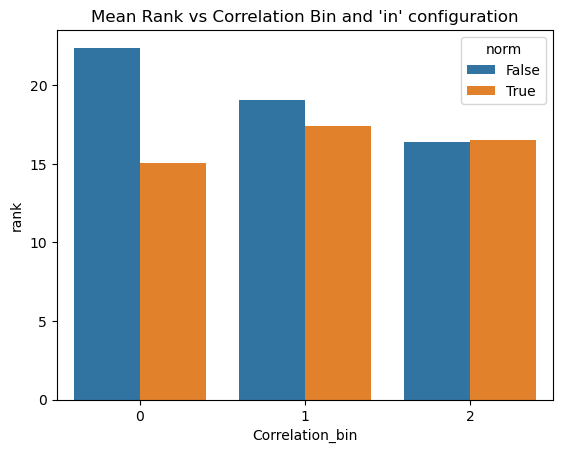

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=result, x='Correlation_bin', y='rank', hue='norm')
plt.title("Mean Rank vs Correlation Bin and 'in' configuration")
plt.show()


In [46]:
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X = df[data_properties + configurations]
y = df['rank']

# One-hot encode the categorical config features
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop=None), ['fusion', 'embed', 'ff'])
], remainder='passthrough')

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeRegressor(max_depth=3))
])

model.fit(X, y)

# Extract rules
tree = model.named_steps['tree']
feature_names = model.named_steps['preprocessor'].get_feature_names_out(data_properties + configurations)
rules = export_text(tree, feature_names=list(feature_names))
print(rules)


|--- remainder__Transition <= 0.05
|   |--- cat__embed_token <= 0.50
|   |   |--- cat__embed_none <= 0.50
|   |   |   |--- value: [14.94]
|   |   |--- cat__embed_none >  0.50
|   |   |   |--- value: [17.53]
|   |--- cat__embed_token >  0.50
|   |   |--- remainder__hlr <= 1.83
|   |   |   |--- value: [17.56]
|   |   |--- remainder__hlr >  1.83
|   |   |   |--- value: [23.87]
|--- remainder__Transition >  0.05
|   |--- remainder__Stationarity <= 0.18
|   |   |--- cat__ff_rnn <= 0.50
|   |   |   |--- value: [27.11]
|   |   |--- cat__ff_rnn >  0.50
|   |   |   |--- value: [19.03]
|   |--- remainder__Stationarity >  0.18
|   |   |--- cat__embed_token <= 0.50
|   |   |   |--- value: [14.44]
|   |   |--- cat__embed_token >  0.50
|   |   |   |--- value: [26.77]



In [47]:
# import pandas as pd
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

# # Data properties and configurations
# data_properties = ['nfeature', 'hlr', 'Correlation', 'Transition', 'Shifting', 'Seasonality', 'Trend', 'Stationarity']
# binary_features = ['norm', 'sd']
# categorical_features = ['fusion', 'embed', 'ff']
# target = 'rank'

# # Function to wrap column names in backticks if necessary
# def safe_col(name):
#     # Add backticks for column names that are reserved keywords or contain special characters
#     return f'`{name}`' if name in ['norm', 'from', 'class', 'if', 'else'] else name

# results = []

# # Assuming df is already loaded as your DataFrame
# # Make sure your df looks like this:
# # df = pd.read_csv("your_data.csv")  # Example, replace with your actual data source

# # Build a formula including multiple data properties and interactions with config
# for prop1 in data_properties:
#             for config in binary_features + categorical_features:
#                 # Create the formula with two properties and interaction terms
#                 if config in categorical_features:
#                     formula = f"{target} ~ Q('{prop1}') * C(Q('{config}'))"
#                 else:
#                     formula = f"{target} ~ Q('{prop1}') * Q('{config}')"

#                 # Fit the model
#                 model = smf.ols(formula=formula, data=df).fit()

#                 # Extract interaction terms and their p-values
#                 for term in model.params.index:
#                     if ':' in term:  # Interaction terms
#                         coef = model.params[term]
#                         pval = model.pvalues[term]
#                         if pval < 0.05:  # Only report significant results
#                             # results.append({
#                             #     'property1': prop1,
#                             #     'config': config,
#                             #     'interaction_term': term,
#                             #     'coef': coef,
#                             #     'p_value': pval,
#                             #     'trend': (
#                             #         "higher " + prop1 + " → better to use "
#                             #         + term.split(':')[1].replace('C(', '').replace(')[T.', '=').replace(']', '')
#                             #         if coef < 0 else
#                             #         "lower " + prop1 + " → better to use "
#                             #         + term.split(':')[1].replace('C(', '').replace(')[T.', '=').replace(']', '')
#                             #     ),
#                             #     'note': f"When {prop1} is {'higher' if coef < 0 else 'lower'},"
#                             #             f" better to use {term.split(':')[1]} (p={pval:.3f}, coef={coef:.3f})"
#                             # })
#                             direction = "higher" if prop1 in term and coef < 0 else "lower"
#                             performance_effect = "improves" if coef < 0 else "worsens"
#                             config_effect = "better to use" if coef < 0 else "worse to use"

#                             results.append({
#                                 'property': prop1,
#                                 'config': config,
#                                 'interaction_term': term,
#                                 'coef': coef,
#                                 'p_value': pval,
#                                 'trend': f"When {prop1} is {direction}, {config_effect} {term.split(':')[1]}",
#                                 'note': (
#                                     f"When {prop1} is {direction}, using {term.split(':')[1]} "
#                                     f"{performance_effect} rank (p={pval:.3f}, coef={coef:.3f})"
#                                 )
#                             })

# # Convert results to DataFrame and sort by p-value
# trend_df = pd.DataFrame(results).sort_values(by='p_value')

# # Show top insights
# for note in trend_df['note']:
#     print(note)

# trend_df = pd.DataFrame(results).sort_values(by='p_value')

# # Save notes to a .txt file
# with open('correlation_notes.txt', 'w') as f:
#     for note in trend_df['note']:
#         print(note)           # Still print to console
#         f.write(note + '\n')  # Also write to file


In [48]:
# import pandas as pd
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

# # Data properties and configurations
# data_properties = ['nfeature', 'hlr', 'Correlation', 'Transition', 'Shifting', 'Seasonality', 'Trend', 'Stationarity']
# binary_features = ['norm', 'sd']
# categorical_features = ['fusion', 'embed', 'ff']
# target = 'rank'

# # Function to wrap column names in backticks if necessary
# def safe_col(name):
#     return f'`{name}`' if name in ['norm', 'from', 'class', 'if', 'else'] else name

# results = []

# # Assuming df is already loaded as your DataFrame
# # df = pd.read_csv("your_data.csv")  # Replace with your actual data source

# # Loop through the properties and features
# for prop1 in data_properties:
#     best_abs_coef_lower = -float('inf')  # Start with the worst possible value for lower direction
#     best_abs_coef_higher = -float('inf')  # Start with the worst possible value for higher direction
#     best_config_lower = None  # Track the best configuration for lower direction
#     best_config_higher = None  # Track the best configuration for higher direction
#     best_pval_lower = None  # Track the p-value of the best result for lower direction
#     best_pval_higher = None  # Track the p-value of the best result for higher direction
#     best_coef_lower = None  # Track the coefficient for lower direction
#     best_coef_higher = None  # Track the coefficient for higher direction

#     # Loop through the configurations (binary + categorical)
#     for config in binary_features + categorical_features:
#         # Create formula for the interaction term
#         if config in categorical_features:
#             formula = f"{target} ~ Q('{prop1}') * C(Q('{config}'))"
#         else:
#             formula = f"{target} ~ Q('{prop1}') * Q('{config}')"
        
#         # Fit the OLS model
#         model = smf.ols(formula=formula, data=df).fit()

#         # Loop through interaction terms in the model
#         for term in model.params.index:
#             if ':' in term:  # Interaction terms only
#                 coef = model.params[term]
#                 pval = model.pvalues[term]
                
#                 # Only consider significant results (p-value < 0.05)
#                 if pval <= 0.05:
#                     # Get the largest absolute coefficient
#                     abs_coef = abs(coef)

#                     if coef < 0:  # If coef is negative, check for "higher" direction
#                         if abs_coef > best_abs_coef_lower:
#                             best_abs_coef_lower = abs_coef
#                             best_config_lower = term.split(':')[1]  # Get the configuration from the interaction term
#                             best_pval_lower = pval
#                             best_coef_lower = coef

#                     elif coef > 0:  # If coef is positive, check for "lower" direction
#                         if abs_coef > best_abs_coef_higher:
#                             best_abs_coef_higher = abs_coef
#                             best_config_higher = term.split(':')[1]  # Get the configuration from the interaction term
#                             best_pval_higher = pval
#                             best_coef_higher = coef

#     # After looping through all configurations, we now print the best results
#     if best_config_lower:
#         results.append(f"When {prop1} is lower, best to use {best_config_lower} to improve rank (p={best_pval_lower:.3f}, coef={best_coef_lower:.3f})")
#     if best_config_higher:
#         results.append(f"When {prop1} is higher, best to use {best_config_higher} to improve rank (p={best_pval_higher:.3f}, coef={best_coef_higher:.3f})")

# # Save to a text file
# with open('correlation_notes.txt', 'w') as f:
#     for note in results:
#         f.write(note + '\n')  # Write results to file

# # Optionally, print the results to the console as well
# for note in results:
#     print(note)


In [49]:
import pandas as pd
import statsmodels.formula.api as smf

# Define properties and configuration features
data_properties = ['nfeature', 'hlr', 'Correlation', 'Transition', 'Shifting', 'Seasonality', 'Trend', 'Stationarity']
binary_features = ['norm', 'sd']
categorical_features = ['fusion', 'embed', 'ff']
target = 'rank'

# Store results
final_notes = []

# Loop over each data property
for prop in data_properties:
    # For each config feature
    for config in binary_features + categorical_features:
        # Create appropriate formula
        if config in categorical_features:
            formula = f"{target} ~ Q('{prop}') * C(Q('{config}'))"
        else:
            formula = f"{target} ~ Q('{prop}') * Q('{config}')"

        # Fit OLS model
        model = smf.ols(formula=formula, data=df).fit()

        # Track best improving config for both 'higher' and 'lower' cases
        best_effects = {
            "higher": {'abs_coef': 0, 'note': None},
            "lower": {'abs_coef': 0, 'note': None}
        }

        for term in model.params.index:
            if ':' in term and model.pvalues[term] <= 0.05:
                coef = model.params[term]
                pval = model.pvalues[term]

                # Determine direction and interpretation
                if coef < 0:
                    # Rank improves as config interacts negatively with higher prop
                    direction = "higher"
                    performance = "improve"
                else:
                    # Rank improves as config interacts negatively with lower prop
                    direction = "lower"
                    performance = "improve"

                # Check if this is the strongest (abs) improving effect for this direction
                if abs(coef) > best_effects[direction]['abs_coef']:
                    best_effects[direction] = {
                        'abs_coef': abs(coef),
                        'note': (
                            f"When {prop} is {direction}, best to use {term.split(':')[1]} "
                            f"to {performance} rank (p={pval:.3f}, coef={coef:.3f})"
                        )
                    }

        # Store notes for both directions if they exist
        for dir_effect in best_effects.values():
            if dir_effect['note']:
                final_notes.append(dir_effect['note'])

# Output to console and file
with open("best_config_by_property_m1.txt", "w") as f:
    for note in final_notes:
        print(note)
        f.write(note + '\n')


When nfeature is lower, best to use Q('norm')[T.True] to improve rank (p=0.000, coef=0.014)
When nfeature is lower, best to use C(Q('fusion'))[T.temporal] to improve rank (p=0.000, coef=0.009)
When nfeature is higher, best to use C(Q('embed'))[T.invert] to improve rank (p=0.000, coef=-0.017)
When nfeature is higher, best to use C(Q('ff'))[T.rnn] to improve rank (p=0.000, coef=-0.016)
When hlr is higher, best to use Q('norm')[T.True] to improve rank (p=0.000, coef=-0.855)
When hlr is higher, best to use C(Q('fusion'))[T.temporal] to improve rank (p=0.014, coef=-0.485)
When hlr is lower, best to use C(Q('embed'))[T.token] to improve rank (p=0.002, coef=1.543)
When hlr is lower, best to use C(Q('ff'))[T.rnn] to improve rank (p=0.000, coef=0.975)
When Correlation is lower, best to use Q('norm')[T.True] to improve rank (p=0.000, coef=35.317)
When Correlation is lower, best to use C(Q('fusion'))[T.temporal] to improve rank (p=0.000, coef=30.041)
When Correlation is higher, best to use C(Q('e

In [50]:
# import pandas as pd
# import statsmodels.formula.api as smf

# data_properties = ['nfeature', 'hlr', 'Correlation', 'Transition', 'Shifting', 'Seasonality', 'Trend', 'Stationarity']
# binary_features = ['norm', 'sd']
# categorical_features = ['fusion', 'embed', 'ff']
# target = 'rank'

# final_notes = []

# for prop in data_properties:
#     for config in binary_features + categorical_features:
#         if config in categorical_features:
#             formula = f"{target} ~ Q('{prop}') * C(Q('{config}'))"
#         else:
#             formula = f"{target} ~ Q('{prop}') * Q('{config}')"

#         model = smf.ols(formula=formula, data=df).fit()

#         # Lists to keep candidate terms
#         higher_candidates = []
#         lower_candidates = []

#         for term in model.params.index:
#             if ':' in term and model.pvalues[term] <= 0.05:
#                 coef = model.params[term]
#                 pval = model.pvalues[term]

#                 # Check term corresponds to interaction with config
#                 if (f"Q('{config}')" not in term) and (f"C(Q('{config}'))" not in term):
#                     continue

#                 # Determine candidate bucket
#                 if coef < 0:
#                     # Negative coef → improvement when property higher
#                     higher_candidates.append((coef, term, pval))
#                 elif coef > 0:
#                     # Positive coef → improvement when property lower
#                     lower_candidates.append((coef, term, pval))

#         # Select best for higher: most negative coef (min coef)
#         if higher_candidates:
#             best_higher = min(higher_candidates, key=lambda x: x[0])
#             coef, term, pval = best_higher
#             final_notes.append(
#                 f"When {prop} is higher, best to use {term.split(':')[1]} to improve rank (p={pval:.3f}, coef={coef:.3f})"
#             )

#         # Select best for lower: smallest positive coef (min positive coef)
#         if lower_candidates:
#             best_lower = min(lower_candidates, key=lambda x: x[0])
#             coef, term, pval = best_lower
#             final_notes.append(
#                 f"When {prop} is lower, best to use {term.split(':')[1]} to improve rank (p={pval:.3f}, coef={coef:.3f})"
#             )

# # Output
# with open("best_config_by_property_m.txt", "w") as f:
#     for note in final_notes:
#         print(note)
#         f.write(note + '\n')


In [51]:
# import pandas as pd
# import statsmodels.formula.api as smf

# # Define your features and target
# data_properties = ['nfeature', 'hlr', 'Correlation', 'Transition', 'Shifting', 'Seasonality', 'Trend', 'Stationarity']
# binary_features = ['norm', 'sd']
# categorical_features = ['fusion', 'embed', 'ff']
# target = 'rank'

# # Placeholder for results
# final_notes = []

# # Loop over each data property
# for prop in data_properties:
#     # Loop over each configuration feature
#     for config in binary_features + categorical_features:
#         # Build the formula
#         if config in categorical_features:
#             formula = f"{target} ~ Q('{prop}') * C(Q('{config}'))"
#         else:
#             formula = f"{target} ~ Q('{prop}') * Q('{config}')"

#         # Fit the model
#         model = smf.ols(formula=formula, data=df).fit()

#         # Track best result for this config at higher/lower prop
#         best_terms = {
#             'higher': {'abs_coef': 0, 'note': None},
#             'lower': {'abs_coef': 0, 'note': None}
#         }

#         # Inspect interaction terms
#         for term in model.params.index:
#             if ':' not in term:
#                 continue
#             if model.pvalues[term] > 0.05:
#                 continue

#             coef = model.params[term]
#             pval = model.pvalues[term]
#             direction = 'higher' if coef < 0 else 'lower'  # coef < 0 → higher improves

#             note = (
#                 f"When {prop} is {direction}, best to use {term.split(':')[1]} "
#                 f"to improve rank (p={pval:.3f}, coef={coef:.3f})"
#             )

#             if abs(coef) > best_terms[direction]['abs_coef']:
#                 best_terms[direction] = {'abs_coef': abs(coef), 'note': note}

#         # Save the best note for each direction
#         for dir_key in ['higher', 'lower']:
#             if best_terms[dir_key]['note']:
#                 final_notes.append(best_terms[dir_key]['note'])

# # Output to console and file
# with open("best_config_by_property_per_direction.txt", "w") as f:
#     for note in final_notes:
#         print(note)
#         f.write(note + '\n')
